# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.99186991653217393

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.x, self.x_hat) #tf.reduce_mean((BCE + KLD + softmax_loss) * lam)
            loss = tf.where(tf.is_nan(self.regularized_loss), 1e-2, self.regularized_loss)
            
            correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = {}

    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
    
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            
            Train.best_acc = 0
            for epoch in range(1, (epochs+1)):
                #print("Step {} | Training Loss:".format(epoch), end = " " )
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    _, train_loss = sess.run([net.train_op, 
                                                           net.regularized_loss, 
                                                           ], #net.summary_op
                                                          feed_dict={net.x: x_train[i,:], 
                                                                     net.y_: y_train[i,:], 
                                                                     net.keep_prob:1})
                    
                    #summary_writer_train.add_summary(summary_str, epoch)
                    #if(train_loss > 1e9):
                    
                    #print("{:.6f}".format(train_loss), end = ", " )
                    
                #print("")
                valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1})
                    
                
                accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                               net.pred, 
                                                               net.actual, net.y], 
                                                              feed_dict={net.x: preprocess.x_test, 
                                                                         net.y_: preprocess.y_test, 
                                                                         net.keep_prob:1})
                #print("*************** \n")
                print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}".format(epoch, train_loss, test_loss, accuracy))
                #print("*************** \n")
                #print("Accuracy on Test data: {}".format(accuracy))

                
                if accuracy > Train.best_acc:
                    Train.best_acc = accuracy
                    Train.pred_value = pred_value
                    Train.actual_value = actual_value
                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                    net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                    Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                    curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                    Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4]

    epochs = [50]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:50 hidden layers:2 features count:4
Step 1 | Training Loss: 0.252819 | Test Loss: 1.335494 | Test Accuracy: 0.837340
Step 2 | Training Loss: 0.246081 | Test Loss: 1.242872 | Test Accuracy: 0.804560
Step 3 | Training Loss: 0.426666 | Test Loss: 1.170087 | Test Accuracy: 0.773510
Step 4 | Training Loss: 2.070724 | Test Loss: 1.197806 | Test Accuracy: 0.798572
Step 5 | Training Loss: 0.199238 | Test Loss: 1.170431 | Test Accuracy: 0.772622
Step 6 | Training Loss: 0.284595 | Test Loss: 18363899904.000000 | Test Accuracy: 0.794225
Step 7 | Training Loss: 0.358729 | Test Loss: 1.952253 | Test Accuracy: 0.790942
Step 8 | Training Loss: 0.283792 | Test Loss: 1.830037 | Test Accuracy: 0.746939
Step 9 | Training Loss: 0.481545 | Test Loss: 1.499974 | Test Accuracy: 0.760202
Step 10 | Training Loss: 0.217502 | Test Loss: 1.522937 | Test Accuracy: 0.780429
Step 11 | Training Loss: 0.532311 | Test Loss: 1.746535 | Test Accuracy: 0.662172
Step 12 | Training Loss: 0.

Step 50 | Training Loss: 0.298219 | Test Loss: 1.667264 | Test Accuracy: 0.823057
Current Layer Attributes - epochs:50 hidden layers:2 features count:16
Step 1 | Training Loss: 0.640810 | Test Loss: 1.818417 | Test Accuracy: 0.810016
Step 2 | Training Loss: 0.656751 | Test Loss: 1.769570 | Test Accuracy: 0.768852
Step 3 | Training Loss: 0.514243 | Test Loss: 1.741167 | Test Accuracy: 0.760468
Step 4 | Training Loss: 0.805485 | Test Loss: 1.959147 | Test Accuracy: 0.430758
Step 5 | Training Loss: 1.121098 | Test Loss: 1.954783 | Test Accuracy: 0.430758
Step 6 | Training Loss: 2.457857 | Test Loss: 1.946828 | Test Accuracy: 0.863999
Step 7 | Training Loss: 0.891402 | Test Loss: 1.941946 | Test Accuracy: 0.848119
Step 8 | Training Loss: 0.630574 | Test Loss: 1.928772 | Test Accuracy: 0.832771
Step 9 | Training Loss: 0.721098 | Test Loss: 1.913166 | Test Accuracy: 0.779143
Step 10 | Training Loss: 0.733707 | Test Loss: 1.909401 | Test Accuracy: 0.723785
Step 11 | Training Loss: 0.885505 | 

Step 2 | Training Loss: 0.575972 | Test Loss: 1.606207 | Test Accuracy: 0.791829
Step 3 | Training Loss: 0.475631 | Test Loss: 1.496930 | Test Accuracy: 0.783579
Step 4 | Training Loss: 0.251908 | Test Loss: 1.451527 | Test Accuracy: 0.773731
Step 5 | Training Loss: 0.191188 | Test Loss: 1.435974 | Test Accuracy: 0.771469
Step 6 | Training Loss: 0.353266 | Test Loss: 1.433434 | Test Accuracy: 0.770538
Step 7 | Training Loss: 0.321228 | Test Loss: 1.485521 | Test Accuracy: 0.832638
Step 8 | Training Loss: 0.206283 | Test Loss: 2.024056 | Test Accuracy: 0.793692
Step 9 | Training Loss: 0.774410 | Test Loss: 1.471002 | Test Accuracy: 0.775994
Step 10 | Training Loss: 0.342147 | Test Loss: 1.488425 | Test Accuracy: 0.768054
Step 11 | Training Loss: 0.618674 | Test Loss: 1.682157 | Test Accuracy: 0.783623
Step 12 | Training Loss: 0.224216 | Test Loss: 1.642806 | Test Accuracy: 0.779542
Step 13 | Training Loss: 0.467796 | Test Loss: 1.769953 | Test Accuracy: 0.778211
Step 14 | Training Loss:

Step 3 | Training Loss: 1.220841 | Test Loss: 1.673403 | Test Accuracy: 0.807443
Step 4 | Training Loss: 0.503419 | Test Loss: 1.592077 | Test Accuracy: 0.783490
Step 5 | Training Loss: 0.388768 | Test Loss: 1.698916 | Test Accuracy: 0.802032
Step 6 | Training Loss: 0.375373 | Test Loss: 2.612799 | Test Accuracy: 0.735096
Step 7 | Training Loss: 0.362716 | Test Loss: 1.649842 | Test Accuracy: 0.772977
Step 8 | Training Loss: 0.339815 | Test Loss: 1.615099 | Test Accuracy: 0.737935
Step 9 | Training Loss: 1.305730 | Test Loss: 1.556346 | Test Accuracy: 0.754924
Step 10 | Training Loss: 0.882117 | Test Loss: 1.540031 | Test Accuracy: 0.781538
Step 11 | Training Loss: 0.501514 | Test Loss: 1.636748 | Test Accuracy: 0.691137
Step 12 | Training Loss: 0.538716 | Test Loss: 1.594422 | Test Accuracy: 0.773643
Step 13 | Training Loss: 0.639882 | Test Loss: 1.797948 | Test Accuracy: 0.810060
Step 14 | Training Loss: 0.653053 | Test Loss: 1.636152 | Test Accuracy: 0.731059
Step 15 | Training Loss

In [10]:
df_results = pd.DataFrame(Train.results)

In [11]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score
279,50,8,4,0.948404,0.870076
337,50,16,4,0.831640,0.867947
338,50,16,4,0.830529,0.867903
341,50,16,4,0.793459,0.864044
105,50,16,2,0.865137,0.863999
340,50,16,4,0.794094,0.863999
219,50,4,4,0.928481,0.862225
278,50,8,4,0.941816,0.859164
357,50,32,4,0.914351,0.858588
356,50,32,4,0.911494,0.858277


In [12]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_nsl_kdd_scores.pkl")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.8399  0.1601]
 [ 0.1168  0.8832]]


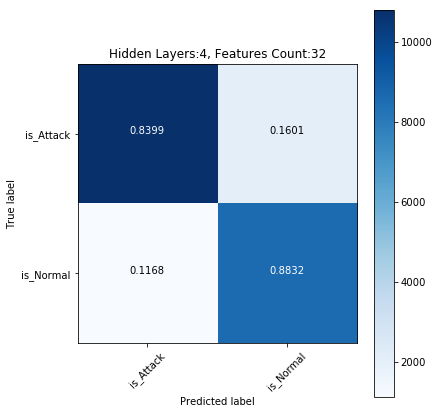

In [14]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)